In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# A closer look at Ryan's rays as input for my simulations

In this notebook, I just want to take a clsoer look at Ryan's rays to understand in detail wehre they come from and where they go to see if/how I can reproduce a similar pattern with simple means and without actually ray-tracing the mirrors. That would allow me to run my simulations with an arbitrary number of rays. Ryan gave me ~64 k rays, which is a lot already, but might not be sufficient for all questions we have.

Here is what Ryan told me about the ray files:

email 1:

    Hi Moritz,

    I've attached a set of rays coming out of the SPO aperture. There are 100 rays per SPO shell, going from R=300 to R=800. I haven't vignetted to the rectangular petal aperture. The array is (6,64600). The first dimension is X, Y, Z position followed by X, Y, Z direction cosines. You should be able to trace these to a focus. Let me know if anything is unclear.

    Ryan

email 2:

    Yes, the PSF is energy dependent. I presumed you were just going to play with general grating layout, so I didn't account for energy here. To do so, I would also include a weight vector with reflectivities.

    Scatter is another matter, and requires knowledge of the surface statistics of the SPOs. That's not something I was going to worry about for Arcus until we win a Phase A.

    Ryan
    
## Ryan's model

Ryan's model

- ray-traces each individual mirror shell
- does currently *not* take scatter due to surface roughness into account

## What am I looking for

If would be great, if I could produce a similar pattern in a simpler way. For example, below I'll try the following:

- Use an ideal mirror
- Add Gaussian scatter with some $\sigma$ in the in-plane and off-plane direction for each ray.

## Coordinate System

I use the cooridnate system with the same definitions that we usually use for Chandra:

- The optical axis coincides with the x-axis.
- An astrophysical source is located at $x = +\infty$.
- Dispersion goes along the y-axis.
- The z-axis is the cross-dispersion direction.
- The origin of the coordinate system is at the focal point, the focal length is 12 m.
- The unit of distance is mm.

Rayn's setup is very similar, except that he uses the z-axis as the optical axis, so I'll switch z and x when reading in his ray file.

In [2]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits

import marxs
import marxs.utils
from marxs.source import PointSource, FixedPointing
from marxs.optics import CircleAperture, PerfectLens, RadialMirrorScatter, FlatDetector
from marxs.simulator import Sequence
from marxs.math.pluecker import h2e

In [3]:
%matplotlib inline

In [4]:
ryan = fits.getdata('../inputdata/160418_SPOTrace.fits')
rp = marxs.utils.generate_test_photons(ryan.shape[1])
for col, indoffset in zip(['pos', 'dir'], [0, 3]):
    rp[col][:, 0] = ryan[2 + indoffset, :]
    rp[col][:, 1] = ryan[1 + indoffset, :]
    rp[col][:, 2] = ryan[0 + indoffset, :]

## Input aperture

In my coordinate system, the entrance aperture is parallel to the yz plane. The plot below shows the position Ryan's rays in yz just as they leave the mirror.
The radius of the inner circle is 300 mm, the outer one is 800 mm. In the y-direction photons are cut to the range -/+187.5 mm.

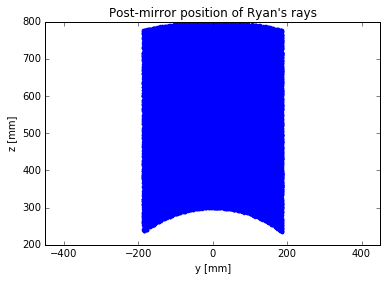

In [5]:
plt.plot(rp['pos'][:, 1], rp['pos'][:, 2], '.')
plt.xlabel('y [mm]')
plt.ylabel('z [mm]')
plt.title("Post-mirror position of Ryan's rays")
plt.axes().set_aspect('equal', 'datalim')

For comparison, I'll make an aperture that matches that shape. I have a pre-mirror aperture and then a mathematically ideal mirror that has no tickness. So, the point where a photons hits that mirror is also the point where it leaves. Thus, the mirror-out position is exactly the same as the mirror-in position.

In [6]:
star = PointSource(coords=(23., 45.))
pointing = FixedPointing(coords=(23., 45.))
photons = star.generate_photons(exposuretime=len(rp) * 2)
p = pointing(photons)
entrancepos = np.array([12000., 0., 0.])

aper = CircleAperture(position=[12200, 0, 0], zoom=800,
                      phi=[-np.pi/4 + np.pi / 2, np.pi/4 + np.pi / 2])

p = aper(p)

xyz = h2e(p['pos'])
indy = np.abs(xyz[:, 1]) < 187.5
r = np.sqrt(xyz[:, 1]**2 + xyz[:, 2]**2)
indr = (r > 300) & (r < 800)

p = p[indy & indr]

# reduce number to match the number or Ryan's rays
p = p[:len(rp)]

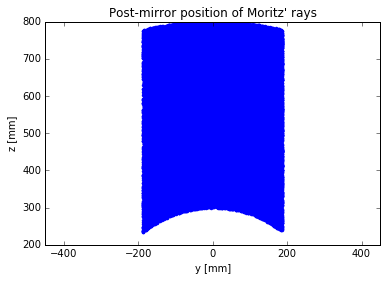

In [7]:
plt.plot(p['pos'][:, 1], p['pos'][:, 2], '.')
plt.xlabel('y [mm]')
plt.ylabel('z [mm]')
plt.title("Post-mirror position of Moritz' rays")
plt.axes().set_aspect('equal', 'datalim')

## Post-mirror direction of rays

This is the most interesting part. I could look at the direction cosines, but I find it easier to visulaize when I just intersect those rays with the focal plane and see what shape I get.

Again, Ryan's rays are just traces through the mirror. I use a perfect mirror (which by itself would put all rays exactly into the focal point), but then add some in-plane and cross-plane scatter. The scatter is drawn from a random distribution; I currently use a Gaussian but any other function is easy to put in the code.
When using sub-aperturing, this gives a bow-tie shaped PSF in the focal plane. I chose this prescription after looking at [Zhang et al. (2012), Fig. 7b](http://proceedings.spiedigitallibrary.org/proceeding.aspx?articleid=1361013), [Allured & McEntaffer (2013), Fig. 9](http://adsabs.harvard.edu/abs/2013ExA....36..661A), and [Willingale et al.](http://athena2.irap.omp.eu/IMG/pdf/sp_14.pdf). That still lets me free to chose the value for the in-plane and off-plane scatter. Most references that show measured point-spread functions give a half-energy width (HEW), but show a PSF that is clearly not rotationally symmetric. Thus, I've looked at [Collon et el. (2014), Fig 2](http://proceedings.spiedigitallibrary.org/proceeding.aspx?articleid=1892036) which shows a measured PSF at the XPBF using two conical mandral that approximate a Wolter-I type geometry and I read of the length-to-width ratio by zooming into that figure and putting a ruler on my screen, which leads me to (Note that the measured values contain a beam divergence of order 1 arcsec):

- in-plane FWHM = 8 arcsec
- transverse FWHM = 1 arcsec

In [8]:
lens = PerfectLens(focallength=12000., position=entrancepos)
# Paper gives FWHM, but input expects Gaussian sigma. Thus, devide by 2.3548
rms = RadialMirrorScatter(inplanescatter=8. / 3600 / 180. * np.pi / 2.3548,
                          perpplanescatter=1. / 3600. / 180. * np.pi / 2.3548,
                          position=entrancepos)

mirror = Sequence(elements=[lens, rms])
mp = mirror(p.copy())

rms2 = RadialMirrorScatter(inplanescatter=8./3.5 / 3600 / 180. * np.pi / 2.3545,
                          perpplanescatter=1./3.5 / 3600. / 180. * np.pi / 2.3548,
                          position=entrancepos)
mirror2 = Sequence(elements=[lens, rms2])
mp2 = mirror2(p.copy())

In [9]:
det = FlatDetector(zoom = 1e4)

In [10]:
rp = det(rp)
mp = det(mp)
mp2 = det(mp2)

(-1, 1)

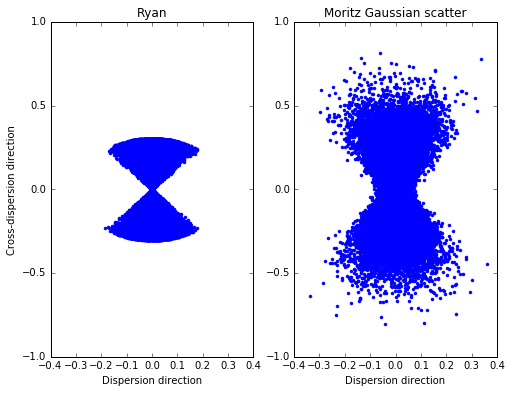

In [11]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(121)
ax1.plot(rp['det_x'], rp['det_y'], '.')

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.plot(mp['det_x'], mp['det_y'], '.')

for ax in [ax1, ax2]:
    ax.set_xlabel('Dispersion direction')

ax1.set_ylabel('Cross-dispersion direction')
    
ax1.set_title('Ryan')
ax2.set_title('Moritz Gaussian scatter')
ax1.set_xlim(ax2.get_xlim())
ax1.set_ylim([-1,1])

The plot shows that I distribute photons to much larger radii. The following plot shows the same data, but binned into a histogram (the scale is linear fomr red to blue, exact number don't matter here).

(-0.3023876726535793, 0.3034473551835235)

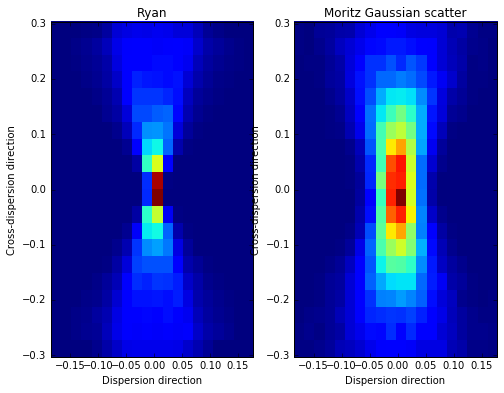

In [12]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(121)
h1 = ax1.hist2d(rp['det_x'], rp['det_y'], bins=20, cmin=0, cmax=5e4)

ax2 = fig.add_subplot(122)
ax2.hist2d(mp['det_x'], mp['det_y'], bins=20, range=[ax1.get_xlim(), ax1.get_ylim()])

for ax in [ax1, ax2]:
    ax.set_xlabel('Dispersion direction')
    ax.set_ylabel('Cross-dispersion direction')
ax1.set_title('Ryan')
ax2.set_title('Moritz Gaussian scatter')
ax2.set_ylim(ax1.get_ylim())

Another instructuve way to look at this it to just plot the distribution in "distance from the center". That is shown below.

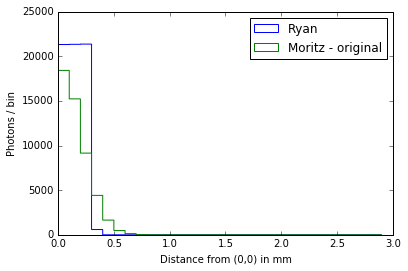

In [13]:
bins = np.arange(0., 3., 0.1)
for p in [rp, mp, mp2]:
    p['d'] = np.sqrt(p['det_x']**2 + p['det_y']**2)

plt.hist(rp['d'], label='Ryan', histtype='step', bins=bins)
plt.hist(mp['d'], label='Moritz - original', histtype='step', bins=bins)
#plt.hist(mp2['d'], label='Moritz - small scatter', histtype='step', bins=bins)
plt.legend()
plt.xlabel('Distance from (0,0) in mm')
plt.ylabel('Photons / bin')

In [14]:
# d is always positive, but to get the std right, we need pos and neg values in there.
for p in [rp, mp]:
    p['d'] = p['d'] * np.sign(p['det_y'])
print "stadard deviation of d in Ryan's rays", np.std(rp['d'])
print "stadard deviation of d in Moritz' rays", np.std(mp['d'])

stadard deviation of d in Ryan's rays 0.174774015177
stadard deviation of d in Moritz' rays 0.201938578264


So, Ryan's rays fill the distance from the center uniformly, while my rays have the Gaussian shape that I prescribed above. So, if I want to reproduce Ryan's rays exactly, then, instead of useing a Gaussian distribution, I should just draw from a uniform distribution over some interval. On the other hand, the measured data generally does not have this sharp cut-off in the PSF, because real mirrors do have a microroughness, shell-to-shell alignment errors, figure errors etc., all of which will blur out any sharp edge that might be theoretically expected. 

**Thus, I will run my simulations either using Ryan's rays (to be totally compatible for comparison) or using my own rays with the settings described above.**